#### https://zhuanlan.zhihu.com/p/83412330
## SHAP介绍
可解释机器学习在这几年慢慢成为了机器学习的重要研究方向。作为数据科学家需要防止模型存在偏见，且帮助决策者理解如何正确地使用我们的模型。越是严苛的场景，越需要模型提供证明它们是如何运作且避免错误的证据

SHAP是Python开发的一个"模型解释"包，可以解释任何机器学习模型的输出。其名称来源于SHapley Additive exPlanation，在合作博弈论的启发下SHAP构建一个加性的解释模型，所有的特征都视为“贡献者”。对于每个预测样本，模型都产生一个预测值，SHAP value就是该样本中每个特征所分配到的数值。

传统的feature importance只告诉哪个特征重要，但我们并不清楚该特征是怎样影响预测结果的。SHAP value最大的优势是SHAP能对于反映出每一个样本中的特征的影响力，而且还表现出影响的正负性。

In [2]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

OSError: Could not load shared object file: llvmlite.dll

In [3]:
# 我们先训练好一个XGBoost model
import xgboost
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

#### Explainer
在SHAP中进行模型解释需要先创建一个explainer，SHAP支持很多类型的explainer(例如deep, gradient, kernel, linear, tree, sampling)，我们先以tree为例，因为它支持常用的XGB、LGB、CatBoost等树集成算法。

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # 传入特征矩阵X，计算SHAP值

#### 单个prediction的解释

In [5]:
# 可视化第一个prediction的解释   如果不想用JS,传入matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

上图的"explanation"展示了每个特征都各自有其贡献，将模型的预测结果从基本值(base value)推动到最终的取值(model output)；将预测推高的特征用红色表示，将预测推低的特征用蓝色表示

基本值(base_value)是我们传入数据集上模型预测值的均值，可以通过自己计算来验证：

In [6]:
y_base = explainer.expected_value
print(y_base)

pred = model.predict(xgboost.DMatrix(X))
print(pred.mean())

14.230186
14.230188


#### 多个预测的解释

In [7]:
shap.force_plot(explainer.expected_value, shap_values, X)

#### summary_plot
为每个样本绘制其每个特征的SHAP值，这可以更好地理解整体模式，并允许发现预测异常值。每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色表示特征值(红色高，蓝色低)。

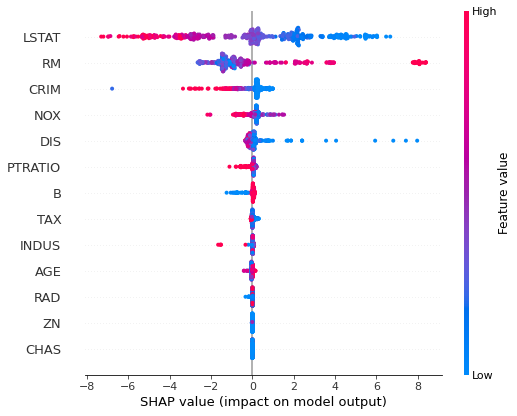

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

#### Feature Importance：
之前提到传统的重要性的计算方法效果不好,SHAP提供了另一种计算特征重要性的思路. 

取每个特征的SHAP值的绝对值的平均值作为该特征的重要性，得到一个标准的条形图(多分类则生成堆叠的条形图)

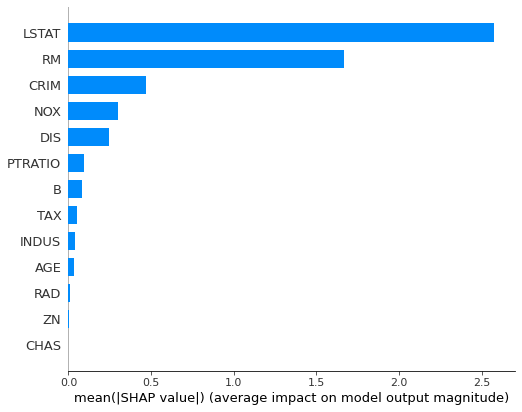

In [17]:
shap.summary_plot(shap_values, X, plot_type="bar")

#### Interaction Values
interaction value是将SHAP值推广到更高阶交互的一种方法。

树模型实现了快速、精确的两两交互计算，这将为每个预测返回一个矩阵，其中主要影响在对角线上，交互影响在对角线外。

这些数值往往揭示了有趣的隐藏关系(交互作用)

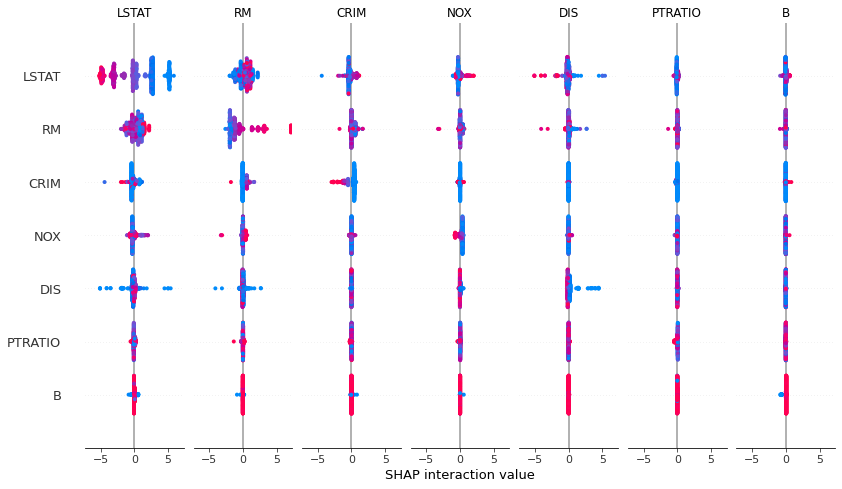

In [18]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)

#### dependence_plot
为了理解单个feature如何影响模型的输出，我们可以将该feature的SHAP值与数据集中所有样本的feature值进行比较。由于SHAP值表示一个feature对模型输出中的变动量的贡献，下面的图表示随着特征RM变化的预测房价(output)的变化。单一RM(特征)值垂直方向上的色散表示与其他特征的相互作用，为了帮助揭示这些交互作用，“dependence_plot函数”自动选择另一个用于着色的feature。在这个案例中，RAD特征着色强调了RM(每栋房屋的平均房间数)对RAD值较高地区的房价影响较小。

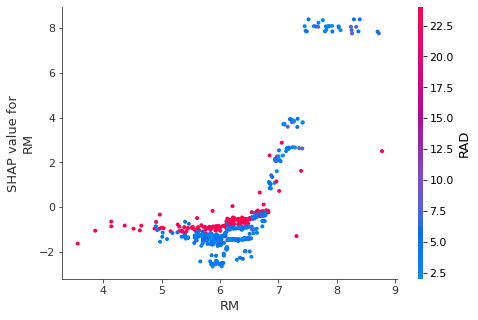

In [19]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

#### 其他类型的explainers
SHAP库可用的explainers有：

deep：用于计算深度学习模型，基于DeepLIFT算法

gradient：用于深度学习模型，综合了SHAP、集成梯度、和SmoothGrad等思想，形成单一期望值方程

kernel：模型无关，适用于任何模型

linear：适用于特征独立不相关的线性模型

tree：适用于树模型和基于树模型的集成算法

sampling ：基于特征独立性假设，当你想使用的后台数据集很大时，kenel的一个很好的替代方案

#### Kernel Explainer：模型无关方法(解释任意模型)
kernel explainer适用于任何模型，但性能不一定是最优的，可能很慢；例如KNN算法只能使用kernel explainer

不过可以用K-mean聚类算法对数据集进行summarizing，这样可以有效提高kenel的速度(当然，会损失一些准确性)

通过SHAP，用knn模型在整个"波士顿房价"数据集上跑完需要1个小时。如果我们牺牲一些精度，通过k-means聚类对数据进行summarizing，可以将时间缩短到3分钟